In [1]:
import pickle
import re
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from pygsp import graphs
%matplotlib inline

## Build Adjacency Matrix

In [76]:
def collect_7_leagues_for_year(year):
    filename="./transfer_data/{}/english_premier_league.csv".format(year)
    eng=pd.read_csv(filename)

    filename="./transfer_data/{}/italian_serie_a.csv".format(year)
    ita=pd.read_csv(filename)

    filename="./transfer_data/{}/french_ligue_1.csv".format(year)
    fra=pd.read_csv(filename)

    filename="./transfer_data/{}/portugese_liga_nos.csv".format(year)
    prt=pd.read_csv(filename)

    filename="./transfer_data/{}/german_bundesliga_1.csv".format(year)
    deu=pd.read_csv(filename)

    filename="./transfer_data/{}/spanish_primera_division.csv".format(year)
    esp=pd.read_csv(filename)

    filename="./transfer_data/{}/dutch_eredivisie.csv".format(year)
    nld=pd.read_csv(filename)
    
    select_league=[eng,ita,fra,prt,deu,esp,nld]
    transfer_7_league=pd.concat(select_league, ignore_index=True)
    return transfer_7_league
collect_7_leagues_for_year(2019).head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season
0,Manchester City,Rodri,23,Defensive Midfield,Atlético Madrid,£63.00m,in,63.0,Premier League,2019,2019/2020
1,Manchester City,João Cancelo,25,Right-Back,Juventus,£58.50m,in,58.5,Premier League,2019,2019/2020
2,Manchester City,Pedro Porro,19,Right-Back,Girona,£10.80m,in,10.8,Premier League,2019,2019/2020
3,Manchester City,Angeliño,22,Left-Back,PSV Eindhoven,£10.80m,in,10.8,Premier League,2019,2019/2020
4,Manchester City,Zack Steffen,24,Goalkeeper,Columbus Crew,£7.20m,in,7.2,Premier League,2019,2019/2020


In [77]:
def collect_7_leagues_for_years(year_start,year_end):
    collect=[]
    for year in range(year_start,year_end+1):
        collect.append(collect_7_leagues_for_year(year))
    select_year=list(range(year_start,year_end+1))
    transfer_7_league_for_years=pd.concat(collect, ignore_index=True)
    return transfer_7_league_for_years
transfer_span=collect_7_leagues_for_years(2010,2019)
transfer_span.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season
0,Arsenal FC,Laurent Koscielny,24.0,Centre-Back,FC Lorient,£11.25m,in,11.25,Premier League,2010,2010/2011
1,Arsenal FC,Sébastien Squillaci,30.0,Centre-Back,Sevilla FC,£5.85m,in,5.85,Premier League,2010,2010/2011
2,Arsenal FC,Wellington Silva,18.0,Right Winger,Fluminense,£3.60m,in,3.60,Premier League,2010,2010/2011
3,Arsenal FC,Marouane Chamakh,26.0,Centre-Forward,G. Bordeaux,Free Transfer,in,0.00,Premier League,2010,2010/2011
4,Arsenal FC,Ryo Miyaichi,18.0,Right Winger,Chukyo HS,?,in,NaN,Premier League,2010,2010/2011


In [78]:
transfer_span.league_name.unique()

"""different names are used:
Primeira Liga = Liga Nos (Liga Portugal)
Primera Division = La Liga (spanish league)
1 Bundesliga = Bundesliga (German league)

To avoid ambiguity, we use the following schema:
'Premier League'
'Serie A'
'Ligue 1'
'Primeira Liga' 
'Bundesliga'
'La Liga'
'Eredivisie'
"""


def league_name_unify(league):
    if league == 'Liga Nos':
        return 'Primeira Liga'
    if league == '1 Bundesliga':
        return 'Bundesliga'
    if league == 'Primera Division':
        return 'La Liga'
    else:
        return league


transfer_span['league_name'] = transfer_span['league_name'].apply(
    league_name_unify)


surplus = ['FC', 'AS', 'CF', '1909', 'Olympique', 'SL',
           'SSC', 'SS', 'UC', 'US', 'HSC', 'OGC', 'UD', 'SV', 'VfL', 'BC', 'SD',
           'LOSC', 'SC',' Balompié','RCD','CD','CS','Calcio']  # ,'RC','RB','SC','CD','CA'



def unify_club_name(column):
    for extra in surplus:
        transfer_span[column] = transfer_span[column].str.replace(
            extra, '') 
    transfer_span[column] = transfer_span[column].str.strip()
    transfer_span[column] = transfer_span[column].apply(lambda x:re.sub('[0-9]+','',x))
    return 
unify_club_name('club_name')
unify_club_name('club_involved_name')

"check if league names are changed"
transfer_span['league_name'].unique()

array(['Premier League', 'Serie A', 'Ligue 1', 'Primeira Liga',
       'Bundesliga', 'La Liga', 'Eredivisie'], dtype=object)

In [79]:
transfer_span.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season
0,Arsenal,Laurent Koscielny,24.0,Centre-Back,Lorient,£11.25m,in,11.25,Premier League,2010,2010/2011
1,Arsenal,Sébastien Squillaci,30.0,Centre-Back,Sevilla,£5.85m,in,5.85,Premier League,2010,2010/2011
2,Arsenal,Wellington Silva,18.0,Right Winger,Fluminense,£3.60m,in,3.60,Premier League,2010,2010/2011
3,Arsenal,Marouane Chamakh,26.0,Centre-Forward,G. Bordeaux,Free Transfer,in,0.00,Premier League,2010,2010/2011
4,Arsenal,Ryo Miyaichi,18.0,Right Winger,Chukyo HS,?,in,NaN,Premier League,2010,2010/2011


In [80]:
"""
Build a reduced transfer DataFrame for  geo-visualization

""";
top_club=transfer_span['club_name'].unique().tolist()

transfer_span_reduced=transfer_span[transfer_span['club_involved_name'].isin(top_club)]

pkl_file = open('./temporary_pkl/transfer_span_reduced.pkl','wb')
pickle.dump(transfer_span_reduced, pkl_file)
pkl_file.close()

In [81]:
#introduce club score data scraped from https://projects.fivethirtyeight.com/global-club-soccer-rankings/
pkl_file = open('./temporary_pkl/club_score_df.pkl','rb')
club_score_df = pickle.load(pkl_file)
pkl_file.close()

In [82]:
club_score_df

,club,score
0,Manchester City,94.2
1,Liverpool,93.8
2,Bayern Munich,93.4
3,Paris Saint-Germain,90.5
4,Real Madrid,89.7
...,...,...
129,Twente Enschede,34.0
130,Emmen,32.0
131,RKC,30.8
132,Fortuna Sittard,28.2


In [83]:
transfer_span_reduced.club_involved_name.unique()[:40]

array(['Lorient', 'Sevilla', 'Hull City', 'Celta de Vigo', 'Juventus',
       'Levante', 'Werder Bremen', 'Fulham', 'Atlético Madrid', 'Monaco',
       'Real Zaragoza', 'Aston Villa', 'Everton', 'Middlesbrough',
       'Reading', 'Wolfsburg', 'Burnley', 'Chelsea', 'Liverpool',
       'Benfica', 'Real Madrid', 'Marseille', 'Arsenal', 'AZ Alkmaar',
       'P Eindhoven', 'Stoke City', 'Crystal Palace', 'Roma',
       'AJ Auxerre', 'Mallorca', 'Villarreal', 'Watford', '.  Köln',
       'Sampdoria', 'Rayo Vallecano', 'Blackpool', 'Sporting CP', 'Lyon',
       'Lazio', 'Brescia'], dtype=object)

In [84]:
len(transfer_span_reduced.club_name.unique())

224

In [85]:
transfer_span_reduced=transfer_span_reduced.merge(club_score_df,left_on='club_name',right_on='club',how='left')
transfer_span_reduced.rename({'score':'club_score'},axis='columns',inplace=True)
transfer_span_reduced.drop(columns='club',inplace=True)

In [86]:
transfer_span_reduced=transfer_span_reduced.merge(club_score_df,left_on='club_involved_name',right_on='club',how='left')
transfer_span_reduced.rename({'score':'club_involved_score'},axis='columns',inplace=True)
transfer_span_reduced.drop(columns='club',inplace=True)

In [87]:
pkl_file = open('./temporary_pkl/avrg_sc_by_league_dict.pkl','rb')
avrg_sc_by_league_dict = pickle.load(pkl_file)
pkl_file.close()

In [88]:
avrg_sc_by_league_dict

{'Bundesliga': 70.156,
 'Eredivisie': 45.506,
 'La Liga': 72.56,
 'Ligue 1': 61.825,
 'Premier League': 74.485,
 'Primeira Liga': 49.572,
 'Serie A': 65.225}

In [89]:
for league in avrg_sc_by_league_dict.keys():
    mask=transfer_span_reduced['league_name']==league
    transfer_span_reduced[mask]=transfer_span_reduced[mask].fillna(avrg_sc_by_league_dict[league])


In [90]:
transfer_span_reduced.head(10)

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season,club_score,club_involved_score
0,Arsenal,Laurent Koscielny,24.0,Centre-Back,Lorient,£11.25m,in,11.25,Premier League,2010,2010/2011,75.6,74.485
1,Arsenal,Sébastien Squillaci,30.0,Centre-Back,Sevilla,£5.85m,in,5.85,Premier League,2010,2010/2011,75.6,80.500
2,Arsenal,Vito Mannone,23.0,Goalkeeper,Hull City,"End of loanMay 8, 2011",in,0.00,Premier League,2010,2010/2011,75.6,74.485
3,Arsenal,Pedro Botelho,20.0,Left-Back,Celta de Vigo,"End of loanJun 30, 2010",in,0.00,Premier League,2010,2010/2011,75.6,74.485
4,Arsenal,Armand Traoré,20.0,Left-Back,Juventus,Loan fee:£450k,out,0.45,Premier League,2010,2010/2011,75.6,84.500
5,Arsenal,Wellington Silva,18.0,Right Winger,Levante,Loan,out,0.00,Premier League,2010,2010/2011,75.6,62.800
6,Arsenal,Vito Mannone,22.0,Goalkeeper,Hull City,Loan,out,0.00,Premier League,2010,2010/2011,75.6,74.485
7,Arsenal,Mikaël Silvestre,33.0,Centre-Back,Werder Bremen,Free Transfer,out,0.00,Premier League,2010,2010/2011,75.6,63.100
8,Arsenal,Philippe Senderos,25.0,Centre-Back,Fulham,Free Transfer,out,0.00,Premier League,2010,2010/2011,75.6,74.485
9,Arsenal,Fran Mérida,20.0,Central Midfield,Atlético Madrid,Free Transfer,out,0.00,Premier League,2010,2010/2011,75.6,86.700


In [91]:
transfer_span_reduced[["club_name","club_involved_name","fee_cleaned","season"]].sort_values(by="fee_cleaned", ascending=False)

,club_name,club_involved_name,fee_cleaned,season
14508,Paris Saint-Germain,Barcelona,199.8,2017/2018
15070,Barcelona,Liverpool,130.5,2017/2018
13548,Liverpool,Barcelona,130.5,2017/2018
16568,Paris Saint-Germain,Monaco,121.5,2018/2019
18515,Benfica,Atlético Madrid,113.4,2019/2020
...,...,...,...,...
8659,Atlético Madrid,Elche,0.0,2014/2015
8660,Atlético Madrid,Saint-Étienne,0.0,2014/2015
8661,Atlético Madrid,Villarreal,0.0,2014/2015
8662,Atlético Madrid,Villarreal,0.0,2014/2015


In [92]:
transfer_span_reduced.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season,club_score,club_involved_score
0,Arsenal,Laurent Koscielny,24.0,Centre-Back,Lorient,£11.25m,in,11.25,Premier League,2010,2010/2011,75.6,74.485
1,Arsenal,Sébastien Squillaci,30.0,Centre-Back,Sevilla,£5.85m,in,5.85,Premier League,2010,2010/2011,75.6,80.500
2,Arsenal,Vito Mannone,23.0,Goalkeeper,Hull City,"End of loanMay 8, 2011",in,0.00,Premier League,2010,2010/2011,75.6,74.485
3,Arsenal,Pedro Botelho,20.0,Left-Back,Celta de Vigo,"End of loanJun 30, 2010",in,0.00,Premier League,2010,2010/2011,75.6,74.485
4,Arsenal,Armand Traoré,20.0,Left-Back,Juventus,Loan fee:£450k,out,0.45,Premier League,2010,2010/2011,75.6,84.500


In [100]:
#unweighted

df_adjacency_reduced=pd.crosstab(transfer_span_reduced['club_name'],transfer_span_reduced['club_involved_name'])
#idx=df_adjacency_reduced.columns.union(df_adjacency_reduced.index).tolist()
idx=transfer_span_reduced['club_name'].unique().tolist()
df_adjacency_reduced=df_adjacency_reduced.reindex(index=idx,columns=idx,fill_value=0)

In [101]:
len(transfer_span_reduced['club_name'].unique().tolist())

224

In [102]:
df_adjacency_reduced

club_involved_name,Arsenal,Stoke City,Wolverhampton Wanderers,Chelsea,Newcastle United,Fulham,West Bromwich Albion,Manchester United,Wigan Athletic,Aston Villa,...,Parma,SPAL,Nîmes,Santa Clara,Huesca,Emmen,Fortuna Sittard,Sheffield United,Famalicão,. Union Berlin
club_name,,,,,,,,,,,,,,,,,,,,,
Arsenal,0,0,0,5,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Stoke City,0,0,0,7,0,3,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
Wolverhampton Wanderers,2,4,0,2,0,2,0,0,0,3,...,0,0,0,0,0,0,0,0,1,0
Chelsea,5,7,0,0,0,10,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
Newcastle United,2,1,0,6,0,3,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Emmen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fortuna Sittard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sheffield United,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
adjacency_reduced=df_adjacency_reduced.values
adjacency_reduced,adjacency_reduced.shape

print("The adjacency matrix for transfer graph is:\n", adjacency_reduced,'\nAnd its shape is {}'.format(adjacency_reduced.shape ))

The adjacency matrix for transfer graph is:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 4 0 ... 0 1 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
And its shape is (224, 224)


In [104]:
# symmetrize the adjacency_reduced matrix, so that the power of adjacency_reduced matrix would imply 
# path between two nodes

adjacency_reduced_sym = ((adjacency_reduced+np.transpose(adjacency_reduced)) != 0)*1

In [105]:
adjacency_reduced_sym_df=((df_adjacency_reduced+df_adjacency_reduced.T)!=0)*1


## Create dict of nodes to clubs

In [106]:
df_adjacency_reduced_reindexed=df_adjacency_reduced.reset_index()

In [107]:
df_adjacency_reduced_reindexed.reset_index().reset_index()[['index','club_name']]

club_involved_name,index,club_name
0,0,Arsenal
1,1,Stoke City
2,2,Wolverhampton Wanderers
3,3,Chelsea
4,4,Newcastle United
...,...,...
219,219,Emmen
220,220,Fortuna Sittard
221,221,Sheffield United
222,222,Famalicão


In [108]:
node2club = pd.Series(
    df_adjacency_reduced_reindexed['club_name'], index=df_adjacency_reduced_reindexed.index).to_dict()
club2node={v:k for k,v in node2club.items()}

In [109]:
club2node['Barcelona']

94

## Build Network&Overview

In [191]:
G = nx.from_numpy_array(adjacency_reduced_sym)

2020-01-04 10:34:17,575:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


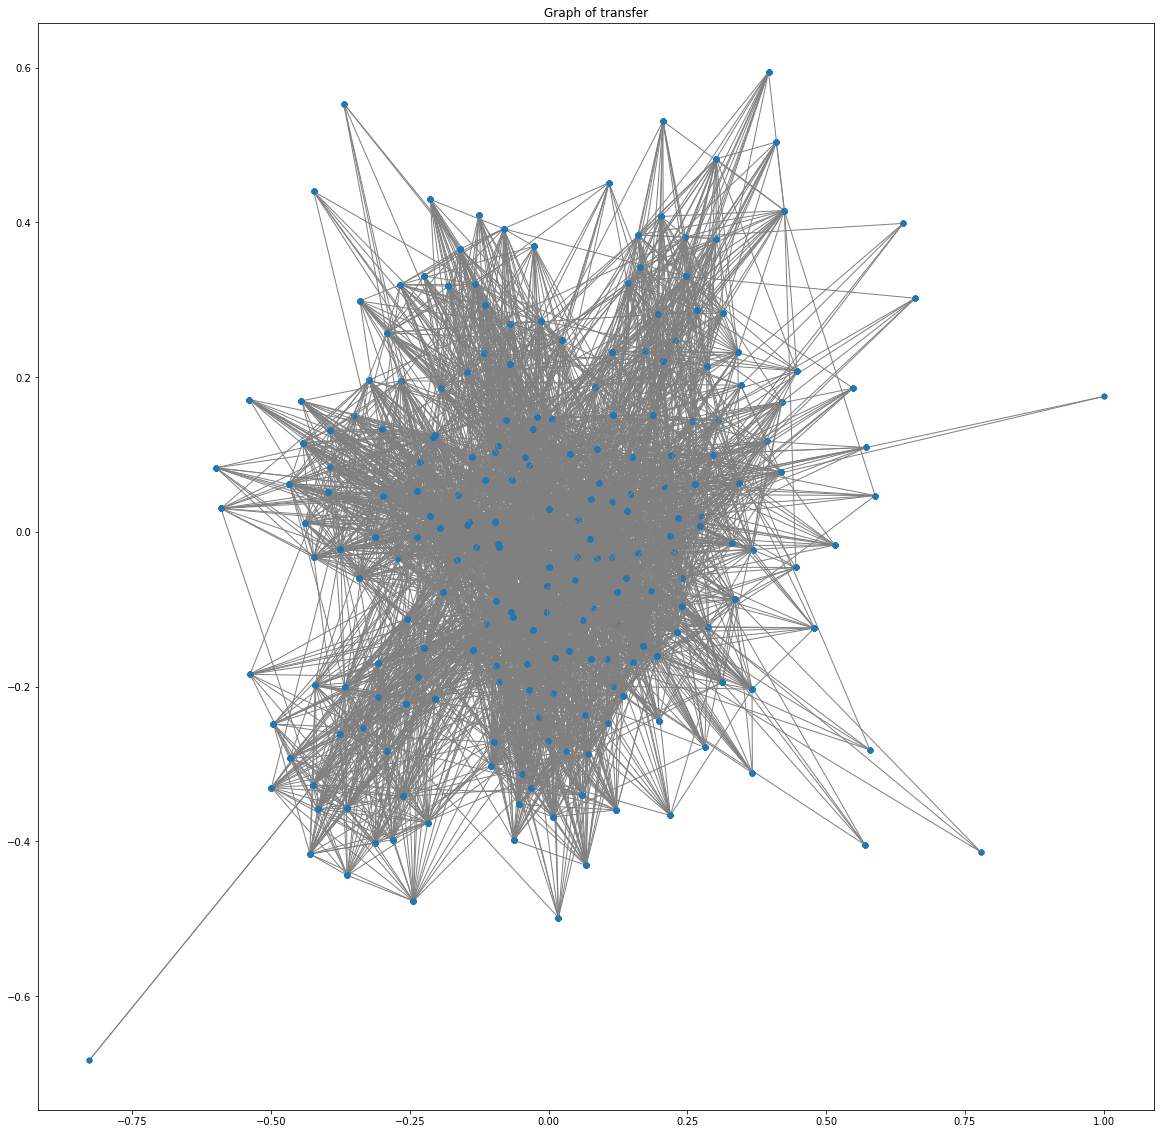

In [111]:
fig, ax = plt.subplots(figsize=(20, 20))
G = graphs.Graph(adjacency_reduced_sym)
G.set_coordinates()
G.plot(backend= 'matplotlib', plot_name = 'Graph of transfer',\
    show_edges = 'True',vertex_size =50, ax = ax, save_as="png")

plt.savefig('./visualization/Graph_of_transfer.png')
plt.show()

In [193]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 224
Number of edges: 4279
Average degree:  38.2054


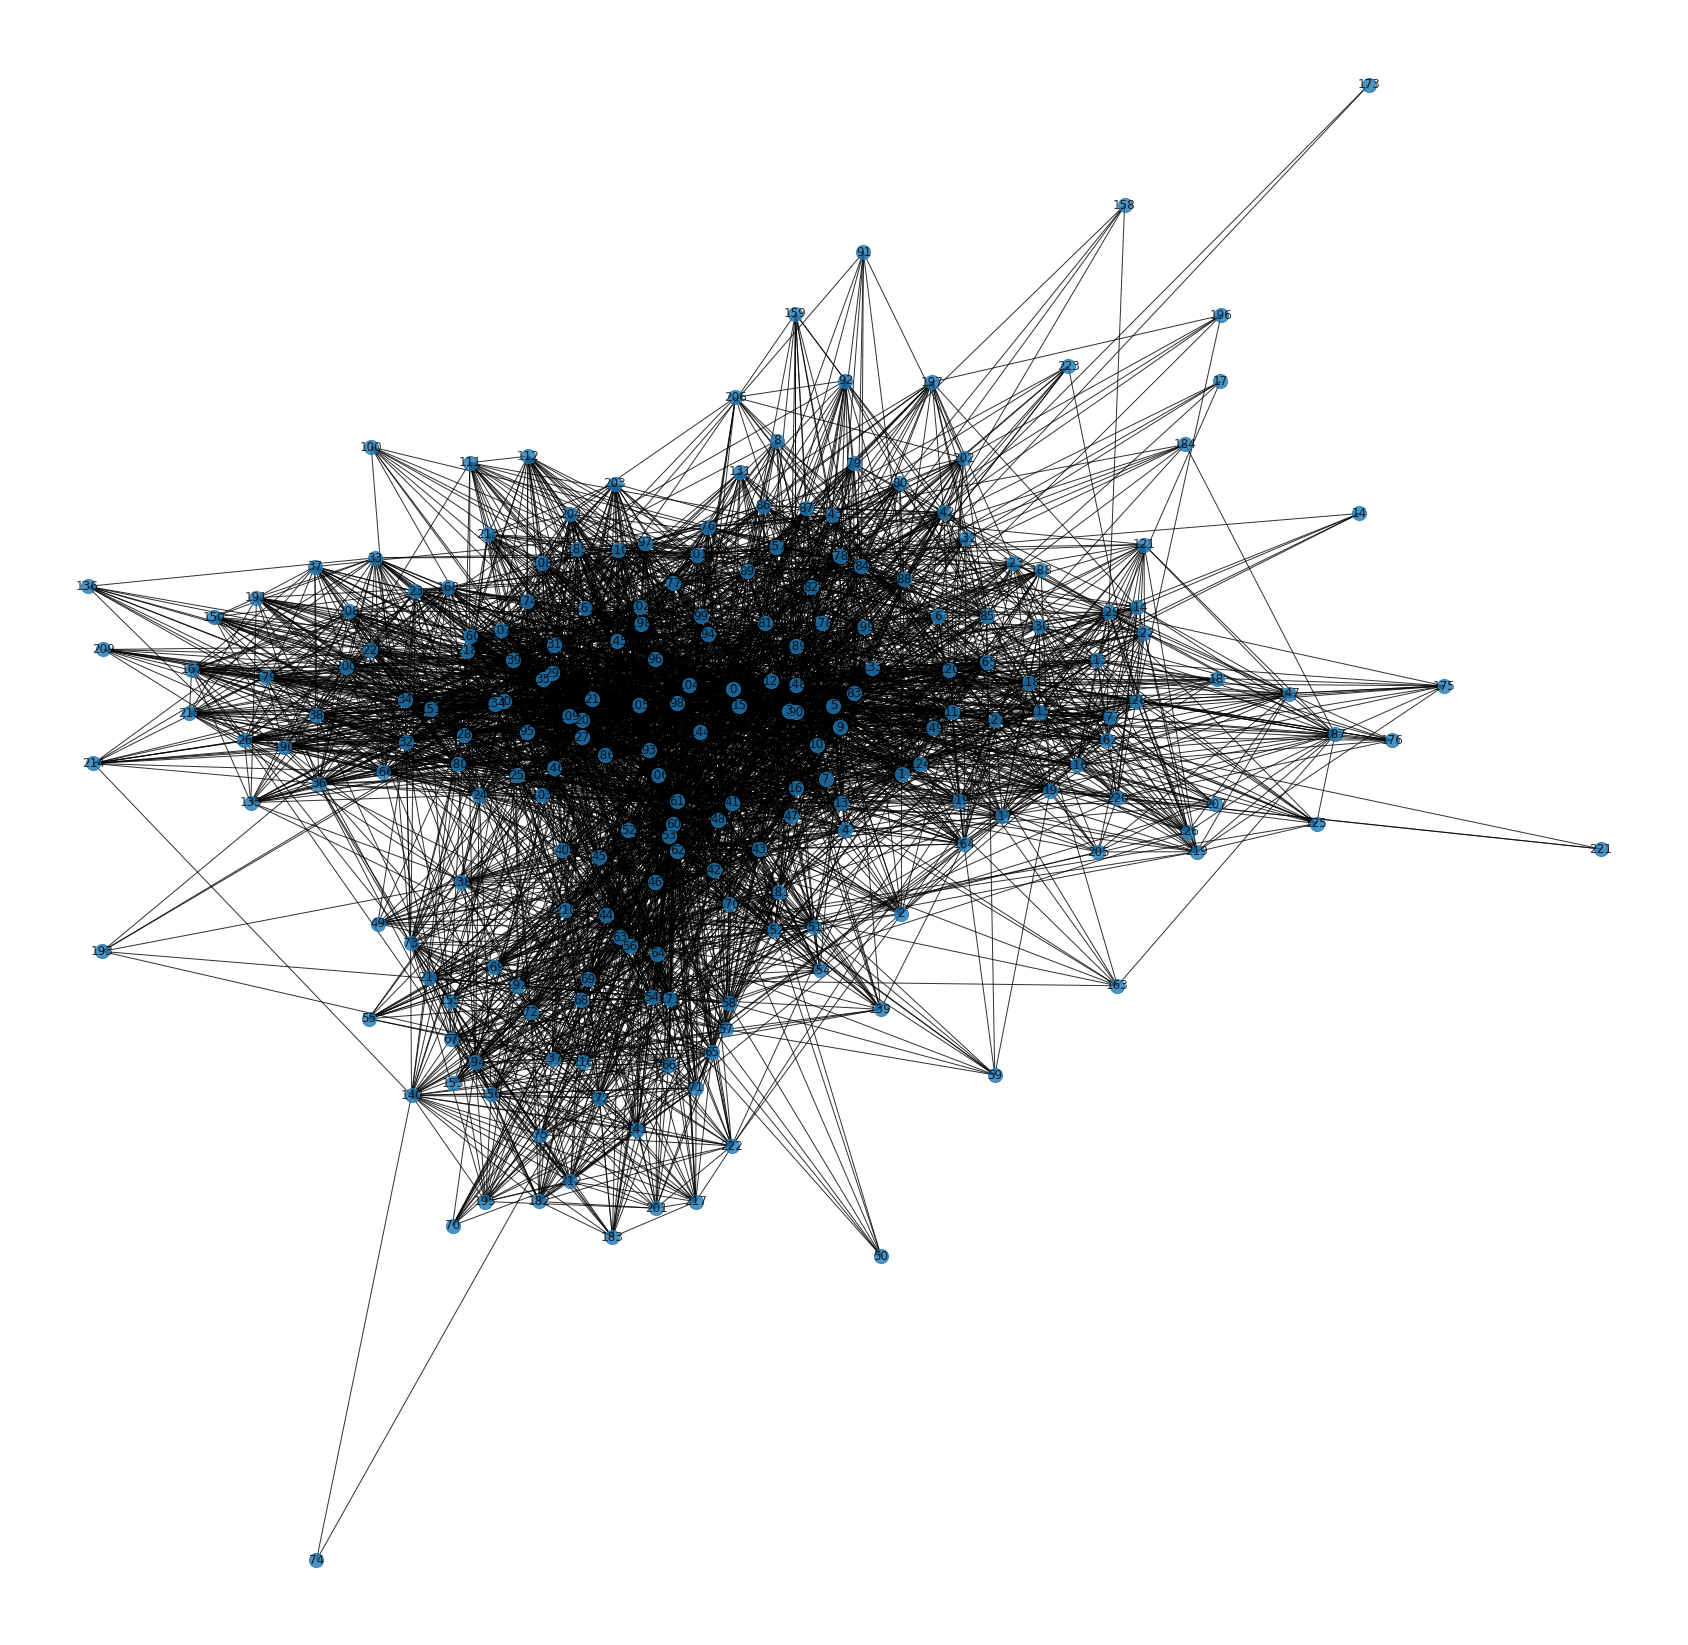

In [220]:
fig, ax = plt.subplots(figsize=(30, 30))

nx.draw_spring(G, with_labels=True, ax=ax, alpha = 0.8,label=True,node_size=200)

In [213]:
#node2club[]

In [215]:
# Helper function for printing various graph properties
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))
describe_graph(G)

Name: 
Type: Graph
Number of nodes: 224
Number of edges: 4279
Average degree:  38.2054
Avg. Shortest Path Length: 1.9182
Diameter: 4.0000
Sparsity: 0.1713
Global clustering coefficient aka Transitivity: 0.3941


## Exploration

### Frequency Distribution

In [112]:

selling=df_adjacency_reduced.sum(axis=0)
selling_rank_df=pd.DataFrame(selling.sort_values(ascending=False).reset_index())

selling_rank_df.columns=['club_involved_name','Num transaction']
selling_rank_df.drop([0,1],inplace=True)
selling_rank_df

,club_involved_name,Num transaction
2,Roma,329
3,AC Milan,317
4,Udinese,313
5,Benfica,312
6,Porto,308
...,...,...
219,Athlétic Club Arlésien,0
220,Novara,0
221,AC Siena,0
222,Swansea City,0


As we can see from the ranking of selling, clubs in Serie A(Italian) has higher number of sells

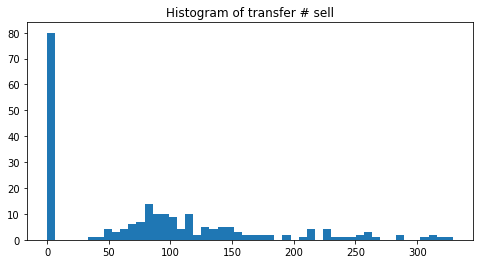

In [113]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of transfer # sell")
plt.hist(selling_rank_df['Num transaction'],bins=50);

In [114]:
#buy
# buying=adjacency_reduced.sum(axis=1)
# buying.sort()
# buying[::-1]


buying=df_adjacency_reduced.sum(axis=1)
buying.sort_values(ascending=False).head(15)

club_name
Genoa C          490
Udinese          419
Juventus         385
Roma             345
Sampdoria        310
AC Milan         294
A Fiorentina     288
Porto            279
Parma            277
Napoli           274
Chelsea          270
Atalanta         257
Braga            252
Chievo Verona    244
Benfica          243
dtype: int64

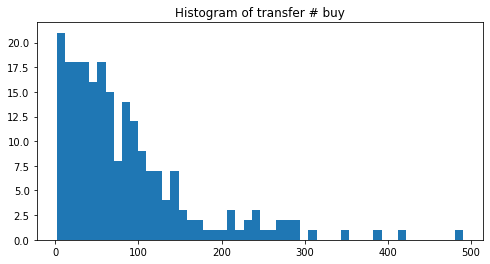

In [115]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of transfer # buy")
plt.hist(adjacency_reduced.sum(axis=1),bins=50);

In [116]:
#trading=selling+buying
trading=selling+buying
trading.sort_values(ascending=False).head(15)
trading_rank_df=pd.DataFrame(trading.sort_values(ascending=False).reset_index())
trading_rank_df.columns=['club_involved_name','Num transaction']
trading_rank_df.drop([0],inplace=True)
trading_rank_df

,club_involved_name,Num transaction
1,Udinese,732
2,Roma,674
3,Chelsea,613
4,AC Milan,611
5,Sampdoria,597
...,...,...
219,Birmingham City,6
220,G Ajaccio,6
221,SpVgg Greuther Fürth,6
222,Eintracht Braunschweig,2


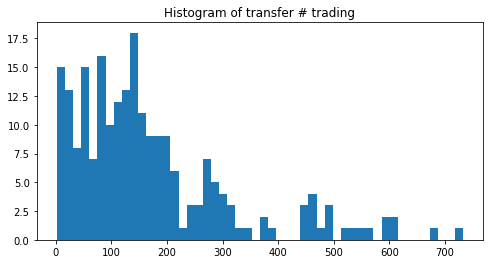

In [117]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of transfer # trading")
plt.hist(trading_rank_df['Num transaction'],bins=50);


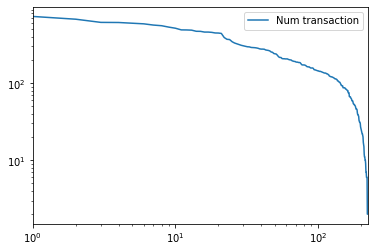

In [118]:
# Does the distribution follow heavy tailed distribution?
trading_rank_df.plot(loglog=True)

In [119]:
distribution_pairs_2darray=pd.DataFrame(trading_rank_df['Num transaction'].value_counts()).reset_index().to_numpy()

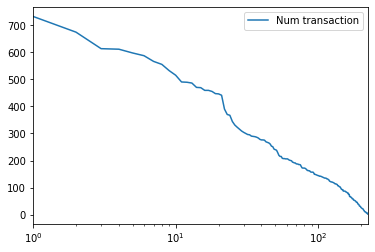

In [120]:
# Does the distribution follow Light tailed distribution?
trading_rank_df.plot(logx=True)


__*Conclusion*__
The distribution follows a light-tailed distribution 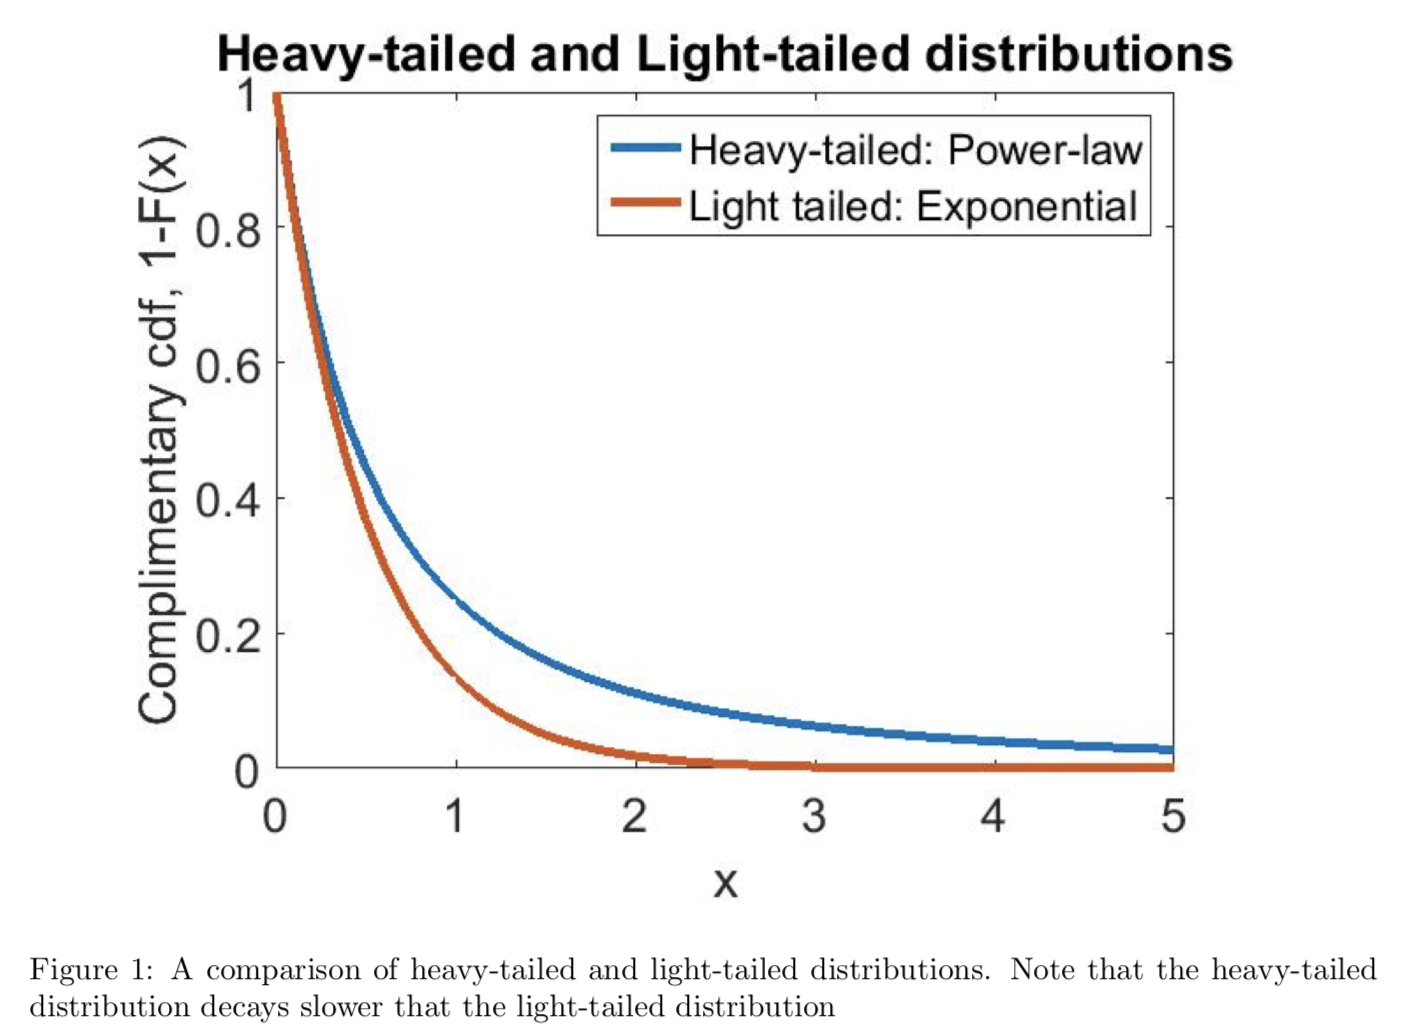

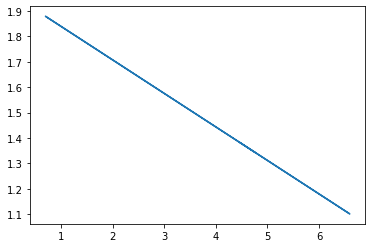

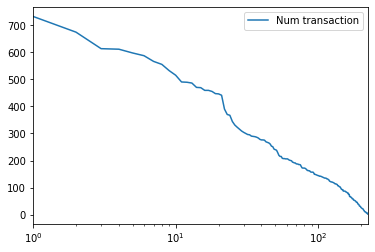

In [121]:
transaction_num=distribution_pairs_2darray[:,0]

frequncy=distribution_pairs_2darray[:,1]

z = np.polyfit(np.log(transaction_num), frequncy, 1)

transaction_num

# def abline(slope, intercept):
#     """Plot a line from slope and intercept"""
#     axes = plt.gca()
#     x_vals = np.array(axes.get_xlim())
#     y_vals = intercept + slope * x_vals
#     plt.plot(x_vals, y_vals, '--')
from numpy.polynomial.polynomial import polyfit
x=np.log(transaction_num)
y=frequncy
b, m = polyfit(x, y, 1)

plt.plot(x, b + m * x, '-')
trading_rank_df.plot(logx=True)  

### Sparsity & clusters

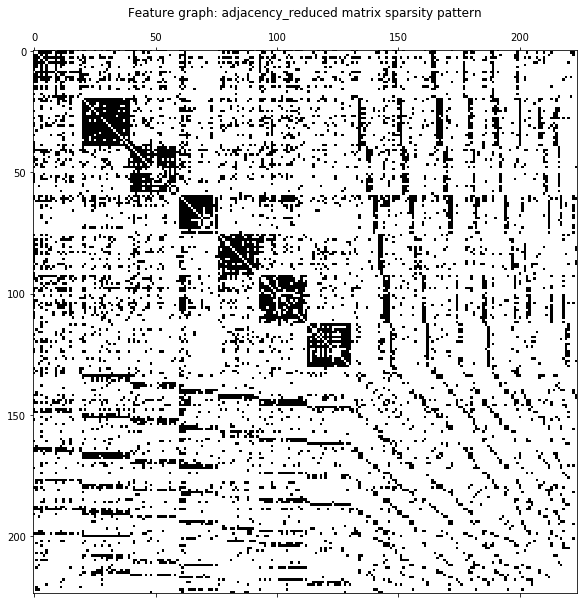

In [122]:
fig, axes = plt.subplots(figsize=(10, 10))
axes.set_title('Feature graph: adjacency_reduced matrix sparsity pattern')
axes.spy(adjacency_reduced_sym)
plt.show()

In [124]:
"""The 7 blocks on the diagonal correspond to ENG,ITA,FRA,PRT,DEU,ESP,NLD
The block correponds to ENG is the least obvious, which means there are less transactions
inside the league than trans-leagues.
""";

$density = \frac{2m}{n(n-1)}$

In [142]:
G = nx.from_numpy_array(adjacency_reduced_sym)
print("density of the graph is {}".format(round(nx.density(G),6)))

density of the graph is 0.171324


### Connectivity

In [143]:
N = 4
path_matrix = np.zeros(adjacency_reduced_sym.shape)
for n in range(1, N+1):
    path_matrix += np.linalg.matrix_power(adjacency_reduced_sym, n)
    print("Can all nodes be connected within {}{}{} steps in transfer grapph? {}{}{}".format(
        '\033[1m', n, '\033[0m', '\033[1m', path_matrix.all() > 0, '\033[0m'))

Can all nodes be connected within 1 steps in transfer grapph? False
Can all nodes be connected within 2 steps in transfer grapph? False
Can all nodes be connected within 3 steps in transfer grapph? False
Can all nodes be connected within 4 steps in transfer grapph? True


In [144]:
print(np.linalg.matrix_power(adjacency_reduced_sym, 6))

[[266056981 143616724  90913511 ...   7763029  51023082  25949418]
 [143616724  78198207  49251669 ...   4284028  27446522  14097962]
 [ 90913511  49251669  31408819 ...   2690813  17959566   8848703]
 ...
 [  7763029   4284028   2690813 ...    252117   1416714    760046]
 [ 51023082  27446522  17959566 ...   1416714  12429520   4980556]
 [ 25949418  14097962   8848703 ...    760046   4980556   2691455]]


In [145]:
print('Number of nodes: {}, Number of edges: {}'. format(G.number_of_nodes(), G.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G.number_of_selfloops(), nx.number_connected_components(G)))

Number of nodes: 224, Number of edges: 4279
Number of self-loops: 3, Number of connected components: 1


The fact that number of connected component is 1 tells us this graph is connected. But not fully connected( diameter$\neq$ 1)

### Diameter

In [146]:
print(f"Diameter according to networkx: {nx.diameter(G)}")

Diameter according to networkx: 4


We see that the diameter of this network is 5, thus the largest path between two nodes in the network is 5. This is indeed  a small value! It tells us our network has __*small-world propriety*__:Any club could be linked via at most 5 transaction. 

### Clustering Coefficient 

In [147]:
nx.average_clustering(G)

0.47957418337883145

In [151]:
clustring_coef_dict=nx.cluster.clustering(G)
clustring_coef_dict={k:v for k,v in sorted(clustring_coef_dict.items(),key=lambda item: item[1],reverse=True)}

In [152]:
node2club[69],node2club[137],node2club[176],node2club[49],node2club[61]

('Rio Ave',
 'AC Ajaccio',
 'Go Ahead Eagles Deventer',
 'Sochaux-Montbéliard',
 'Sporting CP')

In [139]:
top10club = ['Barcelona', 'Real Madrid', 'Atlético Madrid', 'Paris Saint-Germain', 'Borussia Dortmund',
             'Bayern Munich', 'Manchester City', 'Manchester United', 'Juventus', 'AC Milan']

top10club_node=[v for k,v in club2node.items() if k in top10club]

In [154]:
"""Calculate the clustering coefficient for the 10 great clubs"""
[clustring_coef_dict[node] for node in top10club_node]

[0.4295874822190612,
 0.39473684210526316,
 0.3523939808481532,
 0.35919343814080656,
 0.4175475687103594,
 0.38095238095238093,
 0.43902439024390244,
 0.3649122807017544,
 0.411864406779661,
 0.43186582809224316]

<div class="alert alert-block alert-info">
The clustering coefficient for the **10 great European football club** are all relatively **low**. All of them are **below** the average of all 224 clubs. This tells us what ??

In [155]:
len(idx)

224

In [161]:
high_clust_coef_node=[k for k,v in clustring_coef_dict.items() if v>=0.75]

In [162]:
[node2club[node] for node in high_clust_coef_node ]

['Naval º de Maio',
 'Eintracht Braunschweig',
 'SPAL ',
 'Cambuur-Leeuwarden',
 'Delfino Pescara ',
 'Livorno',
 'Novara  ',
 'SPAL',
 'Penafiel',
 'Parma  ',
 'Frosinone',
 'Santa Clara',
 'RC Lens']

<div class="alert alert-block alert-info">
    Small clubs tend to have higher clustering coefficient. 
    Top clubs and small clubs have two transaction models. Top club's transactions are based on talented players, thus they have less fixed trading partner. On the other hand, smaller clubs' transactions are based on budget. To establish a local transaction group network is beneficial for these clubs, they can economize negotiation time and may have a promotion price.

### Centrality

#### Degree Centrality

In [185]:
node2centrality=nx.degree_centrality(G)
node2centrality=dict(sorted(node2centrality.items(),key=lambda x:x[1],reverse=True))

top_centrality_node=[k for (k,v) in node2centrality.items() if v>0.35]
top_centrality_club=[node2club[node] for node in top_centrality_node]
top_centrality_club

['Sporting CP',
 'Chelsea',
 'Sevilla',
 'Monaco',
 'Benfica',
 'Porto',
 'AC Milan',
 'Arsenal',
 'Roma',
 'Liverpool']

####  betweenness Centrality


In [176]:
nx.betweenness_centrality?

In [180]:
node2betw_centrality=nx.betweenness_centrality(G)
node2betw_centrality=dict(sorted(node2betw_centrality.items(),key=lambda x:x[1],reverse=True))

top_betw_centrality_node=[k for (k,v) in node2betw_centrality.items() if v>0.015]
top_betw_centrality_club=[node2club[node] for node in top_betw_centrality_node]
top_betw_centrality_club


['Sporting CP',
 'Monaco',
 'Chelsea',
 'Benfica',
 'Porto',
 'Braga',
 'Udinese',
 '.F Mainz ',
 'Sevilla',
 'AC Milan']

#### page rank

In [184]:
node2page_rank=nx.pagerank(G)
node2page_rank=dict(sorted(node2page_rank.items(),key=lambda x:x[1],reverse=True))
node2page_rank
top_page_rank_node=[k for (k,v) in node2page_rank.items() if v>0.008]
top_page_rank_club=[node2club[node] for node in top_page_rank_node]
top_page_rank_club



['Sporting CP',
 'Chelsea',
 'Monaco',
 'Sevilla',
 'Benfica',
 'Porto',
 'AC Milan',
 'Arsenal',
 'Roma',
 'Liverpool',
 'Juventus']

#### closeness_centrality

In [189]:
node2close_central=nx.closeness_centrality(G)
node2close_central=dict(sorted(node2close_central.items(),key=lambda x:x[1],reverse=True))
node2close_central
top_close_central_node=[k for (k,v) in node2close_central.items() if v>0.60]
top_close_central_club=[node2club[node] for node in top_close_central_node]
top_close_central_club




['Sporting CP',
 'Chelsea',
 'Sevilla',
 'Monaco',
 'Benfica',
 'AC Milan',
 'Porto',
 'Arsenal',
 'Roma',
 'Liverpool',
 'Atlético Madrid']

### Node Attributes

In [260]:
transfer_span_reduced[['club_name','club_score']].drop_duplicates()

,club_name,club_score
0,Arsenal,75.600
10,Stoke City,74.485
24,Wolverhampton Wanderers,74.485
30,Chelsea,85.700
41,Newcastle United,63.300
...,...,...
17464,Emmen,32.000
17497,Fortuna Sittard,28.200
17760,Sheffield United,73.000
18647,Famalicão,43.600


In [221]:
club_score_df

,club,score
0,Manchester City,94.2
1,Liverpool,93.8
2,Bayern Munich,93.4
3,Paris Saint-Germain,90.5
4,Real Madrid,89.7
...,...,...
129,Twente Enschede,34.0
130,Emmen,32.0
131,RKC,30.8
132,Fortuna Sittard,28.2


Text(0, 0.5, 'normalized frequency')

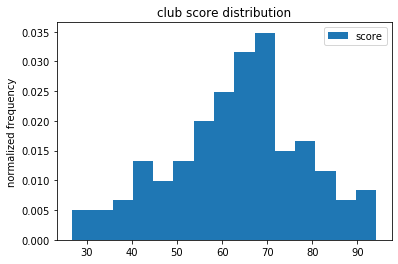

In [243]:
club_score_df.plot(kind='hist',bins=15,density=True)
plt.title('club score distribution')
plt.ylabel('normalized frequency')

### Smoothness & Graph Fourier Transform 

In [246]:
#The warm tells us there is self loop . Use np.fill_diagonal(W, 0) to slove
from pygsp import graphs
G = graphs.Graph(adjacency_reduced_sym)
print('{} nodes, {} edges'.format(G.N, G.Ne))

2020-01-04 15:18:40,327:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


224 nodes, 4279 edges


In [ ]:
f=club_score_df

In [252]:
G.L.todense()

matrix([[83.,  0., -1., ...,  0.,  0.,  0.],
        [ 0., 51., -1., ..., -1., -1.,  0.],
        [-1., -1., 26., ...,  0., -1.,  0.],
        ...,
        [ 0., -1.,  0., ...,  3.,  0.,  0.],
        [ 0., -1., -1., ...,  0., 21.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  9.]])

## Section: Network Model

In [146]:
nx.density(G)

0.004398335760400829

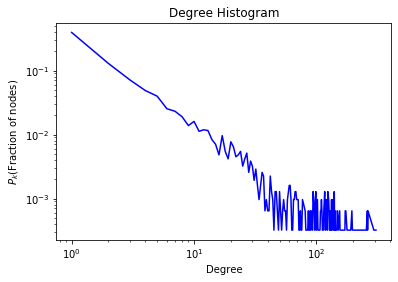

In [140]:
import collections

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
Num_nodes=len(degree_sequence)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cnt_normalized=[elem/Num_nodes for elem in cnt]
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(deg, cnt_normalized, color='b')

plt.title("Degree Histogram")
plt.ylabel("$P_k$(Fraction of nodes)")
plt.xlabel("Degree")

plt.show()

The plot shows degree distribution follows __*power law*__, this is a typical propriety of __*scale-free network.*__

Scale-free networks have:

- many small degree nodes
- not so many nodes around < K >
- high-degree nodes, aka hubs

# Add attributes for nodes in the graph

In [261]:
import sqlite3

con = sqlite3.connect('./large data/database.sqlite')
Team_Attributes_df = pd.read_sql("SELECT * FROM Team_Attributes", con)
Team_df = pd.read_sql("SELECT * FROM Team", con)

In [262]:
Team_Attributes_df

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,1454,15005,10000,2011-02-22 00:00:00,52,Balanced,NaN,Little,52,Mixed,...,53,Normal,Organised,46,Medium,48,Press,53,Normal,Cover
1454,1455,15005,10000,2012-02-22 00:00:00,54,Balanced,NaN,Little,51,Mixed,...,50,Normal,Organised,44,Medium,55,Press,53,Normal,Cover
1455,1456,15005,10000,2013-09-20 00:00:00,54,Balanced,NaN,Little,51,Mixed,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover
1456,1457,15005,10000,2014-09-19 00:00:00,54,Balanced,42.0,Normal,51,Mixed,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover


# Weighted graph

In [185]:
df_adjacency_w = pd.crosstab(
    transfer_7_league['club_name'], transfer_7_league['club_involved_name'], values=transfer_7_league['fee_cleaned'],aggfunc=sum)
idx=sorted(df_adjacency.columns.union(df_adjacency.index).tolist())
df_adjacency=df_adjacency.reindex(index=idx,columns=idx,fill_value=0)

In [188]:
df_adjacency_w.fillna(value=0,inplace=True)

In [189]:
df_adjacency_w

club_involved_name,1. FC Köln,1.FC Heidenheim,1.FC Köln II,1.FC Köln U19,1.FC Magdeburg,1.FC Nuremberg,1.FK Pribram,1.FSV Mainz 05,1860 Munich,1º de Agosto,...,Zaglebie Lubin,Zalgiris,Zamalek,Zenit S-Pb,Zlate Moravce,Zulte Waregem,Águeda,Águia,Östersund,Ümraniyespor
club_name,,,,,,,,,,,,,,,,,,,,,
1. FC Köln,0.0,0.0,0.0,0.0,0.00,0.27,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.FC Union Berlin,0.0,0.9,0.0,0.0,0.36,0.00,0.0,1.80,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.FSV Mainz 05,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC Milan,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACF Fiorentina,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vitória Setúbal FC,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Watford FC,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
West Ham United,0.0,0.0,0.0,0.0,0.00,0.00,0.0,6.75,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
df_adjacency_w.sum(axis=0).sort_values(ascending=False).head(10)

club_involved_name
Atlético Madrid    479.250
Real Madrid        351.000
Juventus           346.500
FC Barcelona       323.460
Sevilla FC         204.710
Ajax               201.555
Monaco             199.350
Benfica            195.300
Man Utd            190.350
Man City           189.270
dtype: float64